# Data Analysis of Olivocerebellar Model

## Table of Contents
### 1. Import All
    1. Import packages
    2. Import data of simulations
### 2. Split Data - Before/After Adaptation
### 3. Purkinje Cell 
    1. Input current
    2. 
### 4. Inferior Olive
    1.
### 5. Correlations
    1. IO - IO
    

## 1. Import All

In [88]:
# 1.1) Import packages
import numpy as np
from brian2 import*
import NeuroTools as nt
from NeuroTools import signals, analysis
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy.io as sio
import seaborn as sns
#import plotpy.express as px
class Struct:
    pass

# 1.2) Import data of simulations
nameInput = 'NoiseDS_test2'
name_simparam = nameInput + '_SimParams'
name_VoltCell = nameInput + '_VoltageCell'
name_SpikeT = nameInput + '_SpikeTimes'
name_PV = nameInput + '_PlasticityVariables'
name_Input = nameInput + 'AfterSim'

SimParam = sio.loadmat(name_simparam)
VoltCell = sio.loadmat(name_VoltCell)
SpikeTimes = sio.loadmat(name_SpikeT)
PlasticityVar = sio.loadmat(name_PV)
Input = sio.loadmat(name_Input)

## 2. Split Data - Before/After Adaptation

In [89]:
# 2) Split Data - before/after adaptation    

# before = start_t:t_beforeAdaptation
# after = t_beforeAdaptaion:end
# indicated by BA (BeforeAdaptation) and AA (AfterAdaptation) accordingly


start_t = 1000 # remove first second of data due to transient
t_beforeAdaptation = int(len(Input['Input']['I'][0][0][0])/2) # halfway the simulation
nrInputs=Input['Input']['I'][0][0].shape[0] # number of inputs
nrPC = VoltCell['VoltCell']['PC'][0][0].shape[0]
nrDCN = VoltCell['VoltCell']['DCN'][0][0].shape[0]
nrIO = VoltCell['VoltCell']['IOsoma'][0][0].shape[0]
nrDummy = nrPC*nrInputs
lengthSim =VoltCell['VoltCell']['PC'][0][0].shape[1]
# Input to the system
Input_s = Struct()
Input_s_I = [Input['Input']['I'][0][0][k][start_t:] for k in range(0,nrInputs)]
Input_s.I_BA= [Input['Input']['I'][0][0][k][start_t:t_beforeAdaptation] for k in range(0,nrInputs)]
Input_s.nweight_BA=[Input['Input']['nweight'][0][0][k][start_t:t_beforeAdaptation] for k in range(0,nrDummy)]
Input_s.I_AA =[Input['Input']['I'][0][0][k][t_beforeAdaptation:] for k in range(0,nrInputs)]
Input_s.nweight_AA =[Input['Input']['nweight'][0][0][k][t_beforeAdaptation:] for k in range(0,nrDummy)]
#print(size(Input_s.I_BA))
# Membrane potentials of all the different cells
VoltCell_s = Struct()
VoltCell_s.PC = [VoltCell['VoltCell']['PC'][0][0][k][start_t:] for k in range(0,nrPC)]
VoltCell_s.PC_BA = [VoltCell['VoltCell']['PC'][0][0][k][start_t:t_beforeAdaptation] for k in range(0,nrPC)]
VoltCell_s.PC_AA = [VoltCell['VoltCell']['PC'][0][0][k][t_beforeAdaptation:] for k in range(0,nrPC)]
VoltCell_s.DCN = [VoltCell['VoltCell']['DCN'][0][0][k][start_t:] for k in range(0,nrDCN)]
VoltCell_s.DCN_BA =[VoltCell['VoltCell']['DCN'][0][0][k][start_t:t_beforeAdaptation] for k in range(0,nrDCN)]
VoltCell_s.DCN_AA =[VoltCell['VoltCell']['DCN'][0][0][k][t_beforeAdaptation:] for k in range(0,nrDCN)]
VoltCell_s.IOsoma =[VoltCell['VoltCell']['IOsoma'][0][0][k][start_t:] for k in range(0,nrIO)]
VoltCell_s.IOsoma_BA =[VoltCell['VoltCell']['IOsoma'][0][0][k][start_t:t_beforeAdaptation] for k in range(0,nrIO)]
VoltCell_s.IOsoma_AA =[VoltCell['VoltCell']['IOsoma'][0][0][k][t_beforeAdaptation:] for k in range(0,nrIO)]
VoltCell_s.IOdend =[VoltCell['VoltCell']['IOdend'][0][0][k][start_t:] for k in range(0,nrIO)]
VoltCell_s.IOdend =[VoltCell['VoltCell']['IOdend'][0][0][k][start_t:t_beforeAdaptation] for k in range(0,nrIO)]
VoltCell_s.IOdend =[VoltCell['VoltCell']['IOdend'][0][0][k][t_beforeAdaptation:] for k in range(0,nrIO)]
SpikePC=[]

# Spike Times of all cells
SpikeTimes_s = Struct()
for p in range(0,nrPC):
    nr = str(p)
    PCnr = "PC" + nr
    BA_PCnr = 'PC_BA' + nr
    AA_PCnr = 'PC_AA'+ nr
    nrSpikesPC = SpikeTimes['SpikeTimes']['PC'][0][0][0][p][0].shape[0]
    setattr(SpikeTimes_s, PCnr, [SpikeTimes['SpikeTimes']['PC'][0][0][0][p][0][k] for k in range(0,nrSpikesPC) if SpikeTimes['SpikeTimes']['PC'][0][0][0][p][0][k]>=(start_t/1e3)])
    setattr(SpikeTimes_s, BA_PCnr, [SpikeTimes['SpikeTimes']['PC'][0][0][0][p][0][k] for k in range(0,nrSpikesPC) 
                                    if (SpikeTimes['SpikeTimes']['PC'][0][0][0][p][0][k]>=(start_t/1e3) 
                                        and SpikeTimes['SpikeTimes']['PC'][0][0][0][p][0][k]<=(lengthSim/(2*1e3)))])
    setattr(SpikeTimes_s, AA_PCnr, [SpikeTimes['SpikeTimes']['PC'][0][0][0][p][0][k] for k in range(0,nrSpikesPC) 
                                    if SpikeTimes['SpikeTimes']['PC'][0][0][0][p][0][k]>=(t_beforeAdaptation/1e3)])
for p in range(0,nrDCN):
    nr = str(p)
    DCNnr = "DCN" + nr
    BA_DCNnr = 'DCN_BA' + nr
    AA_DCNnr = 'DCN_AA'+ nr
    nrSpikesDCN = SpikeTimes['SpikeTimes']['DCN'][0][0][0][p][0].shape[0]
    setattr(SpikeTimes_s, DCNnr, [SpikeTimes['SpikeTimes']['DCN'][0][0][0][p][0][k] for k in range(0,nrSpikesDCN) 
                                  if SpikeTimes['SpikeTimes']['DCN'][0][0][0][p][0][k]>=(start_t/1e3)])
    setattr(SpikeTimes_s, BA_DCNnr, [SpikeTimes['SpikeTimes']['DCN'][0][0][0][p][0][k] for k in range(0,nrSpikesDCN) 
                                    if (SpikeTimes['SpikeTimes']['DCN'][0][0][0][p][0][k]>=(start_t/1e3) 
                                        and SpikeTimes['SpikeTimes']['DCN'][0][0][0][p][0][k]<=(lengthSim/(2*1e3)))])
    setattr(SpikeTimes_s, AA_DCNnr, [SpikeTimes['SpikeTimes']['DCN'][0][0][0][p][0][k] for k in range(0,nrSpikesDCN) 
                                    if SpikeTimes['SpikeTimes']['DCN'][0][0][0][p][0][k]>=(t_beforeAdaptation/1e3)])

for p in range(0,nrIO):
    nr = str(p)
    IOnr = "IO" + nr
    BA_IOnr = 'IO_BA' + nr
    AA_IOnr = 'IO_AA'+ nr
    findspikes, _ = find_peaks(VoltCell['VoltCell']['IOsoma'][0][0][p], height=0.0, distance = 10)
    findspikes = findspikes/1000
    nrSpikesIO = len(findspikes)
    setattr(SpikeTimes_s, IOnr, [findspikes[k] for k in range(0,nrSpikesIO)
                                 if findspikes[k]>=(start_t/1e3)])
    setattr(SpikeTimes_s, BA_IOnr, [findspikes[k] for k in range(0,nrSpikesIO) 
                                    if (findspikes[k]>=(start_t/1e3) and findspikes[k]<=(lengthSim/(2*1e3)))])
    setattr(SpikeTimes_s, AA_IOnr, [findspikes[k] for k in range(0,nrSpikesIO) 
                                    if findspikes[k]>=(t_beforeAdaptation/1e3)])
    

### 3. Purkinje Cell

In [90]:
# 3.1 Input current 

# The IO cells that are connected to the Purkinje cells. 
# Position 1 of the vector corresponds to PC1, 2 to PC2 etc.
connectionVectorIO = [9,10, 18, 17, 0, 6, 5, 12, 16, 11]

IOdummyConn = [9, 10, 18, 17, 0, 6, 5, 12, 16, 11, 9, 10, 18, 17, 0, 6, 5, 12, 16, 11, 9, 10, 18, 17, 0, 6, 5, 12, 16, 11, 9, 10, 18, 17, 0, 6, 5, 12, 16, 11, 9, 10, 18, 17, 0, 6, 5, 12, 16, 11]

InputCurrentPC = Struct()

for i in range(0,nrInputs):
    # Create names for the inputs
    name='PC'+str(i)
    total = name + 'total'
    
    # Connectivity between PC-dummy
    steps =np.arange(i,nrDummy,nrPC)
    
    # Multiply the current times the weight
    current = [Input_s.nweight_BA[steps[k]]*Input_s.I_BA[i] for k in range(0,len(steps))]
    
    # Sum over the column to get the total amount of current
    summedcurrent = sum(current,axis=0)
    
    # Set the currents to their attribute
    setattr(InputCurrentPC, name, current)
    setattr(InputCurrentPC, total, summedcurrent)


### 5. Correlations

WARNING    C:\Users\thoed\Anaconda3\envs\brian\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
 [py.warnings]


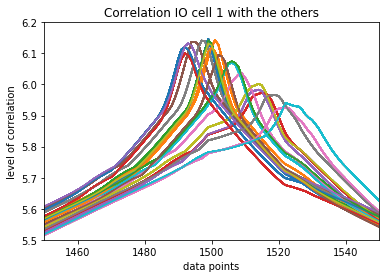

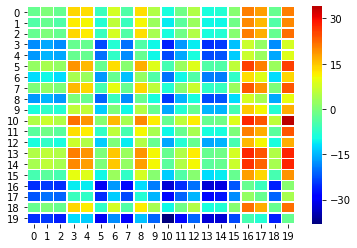

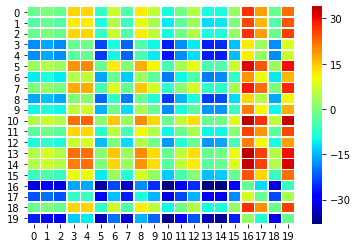

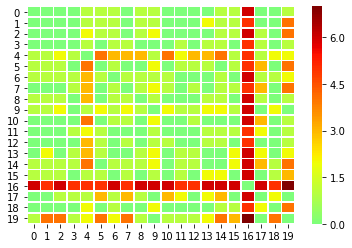

In [113]:
delayIO_BA = np.empty([nrIO,nrIO])
delayIO_AA = np.empty([nrIO,nrIO])
diffDelay = np.empty([nrIO,nrIO])
for i in range(0,nrIO):
    # Correlation Before Adapatation
    corr_BA=[correlate(VoltCell_s.IOsoma_BA[i],VoltCell_s.IOsoma_BA[k],'full') for k in range(0,nrIO)]
    corr_AA = [correlate(VoltCell_s.IOsoma_AA[i],VoltCell_s.IOsoma_AA[k],'full') for k in range(0,nrIO)]
    #print(corr_BA)
    #print(len(VoltCell_s.IOsoma_AA[i]))
    #lagIO_BA=numpy.where(corr_BA[i] == numpy.amax(corr_BA[i]))
    
    lagTotal_BA = [corr_BA[k].argmax()-len(VoltCell_s.IOsoma_BA[i])-1 for k in range(0,nrIO)]
    lagTotal_AA = [corr_AA[k].argmax()-len(VoltCell_s.IOsoma_AA[i])-1 for k in range(0,nrIO)]
    #print(lagTotal_AA)
    #lagTotal_BA = asarray([(asarray(lagRest_BA[k][0])-asarray(lagIO_BA[0][0])) for k in range(0,nrIO)])
    #lagTotal_BA = lagTotal_BA.reshape(nrIO)
    #print(lagIO_BA)
#print(lagRest_BA)
#print(lagTotal_BA)
    #lagIO_AA=numpy.where(corr_AA[i] == numpy.amax(corr_AA[i]))
    #lagRest_AA = [numpy.where(corr_AA[k] == numpy.amax(corr_AA[k])) for k in range(0,nrIO)]
    #lagTotal_AA = asarray([(asarray(lagRest_AA[k][0])-asarray(lagIO_AA[0][0])) for k in range(0,nrIO)])
    #lagTotal_AA = lagTotal_AA.reshape(nrIO)

    delayIO_BA[i] = lagTotal_BA
    delayIO_AA[i] = lagTotal_AA
    
    if i==0:
        plt.figure()
        for l in range(0,nrIO):
            plt.plot(transpose(corr_BA))
        #print(len(corr_A[0]))
        #print(len(corr_BA))
        plt.title('Correlation IO cell 1 with the others')
        plt.xlabel('data points')
        plt.ylabel('level of correlation')
        ax1=plt.subplot(111)
        for l in range(0,nrIO):
            plt.plot(transpose(corr_BA))
        ax1.set_xlim([1450, 1550])
        ax1.set_ylim([5.5,6.2])
        plt.show()
            
            
    #print(lagTotal_AA[:])

    diffDelay[i] = abs(asarray(lagTotal_AA)-asarray(lagTotal_BA))

#print(delayIO_BA[:])
#print(delayIO_AA[0])
#print(diffDelay[0])
figure()
ax = sns.heatmap(delayIO_BA, center=0,cmap='jet',linewidths=.5)

figure()
sx = sns.heatmap(delayIO_AA, center=0, cmap='jet', linewidths=.5)

figure()
df = sns.heatmap(diffDelay,center=0, cmap='jet', linewidths=.5)


In [105]:
print(SimParam)
size(VoltCell_s.IOsoma_AA[1])

{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Wed Jan  8 14:15:58 2020', '__version__': '1.0', '__globals__': [], 'SimParams': array([[(array(['yes'], dtype='<U3'), array(['yes'], dtype='<U3'), array([[2.5e-05]]), array([[2.5]]), array(['both'], dtype='<U4'), array([[10]]), array([[20]]), array([[20]]))]],
      dtype=[('saving', 'O'), ('plotting', 'O'), ('dt', 'O'), ('exp_runtime', 'O'), ('IO_response', 'O'), ('N_Cells_PC', 'O'), ('N_Cells_DCN', 'O'), ('N_Cells_IO', 'O')])}


2500

In [ ]:
Volt